In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

2021-10-11 09:13:56.378277: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


'2.5.0'

In [6]:
weather = pd.read_csv('donetsk_17_21_with_prev_data_storms.csv', sep=';', header=0, parse_dates=True, squeeze=True)
code = weather.pop('code')

In [7]:
weather['wind_direction'] = weather['wind_direction']*10
wv = weather.pop('wind_speed')

# Convert to radians.
wd_rad = weather.pop('wind_direction')*np.pi / 180

# Calculate the wind x and y components.
weather['w_x'] = wv*np.cos(wd_rad)
weather['w_y'] = wv*np.sin(wd_rad)

weather['w_d_prev'] = weather['w_d_prev']*10
wv_p = weather.pop('w_s_prev')

wd_rad_p = weather.pop('w_d_prev')*np.pi / 180

weather['w_x_prev'] = wv_p*np.cos(wd_rad_p)
weather['w_y_prev'] = wv_p*np.sin(wd_rad_p)
weather.head()

,started_at,cloud_height,cloud_amount,temperature,temperature_dew,pressure,pressure_tendency,pressure_tendency_value,temp_prev,dew_prev,w_x,w_y,w_x_prev,w_y_prev
0,2017-09-01 00:00:00,5,8,14.4,13.5,989.4,7,1.3,14.8,13.7,0.000000,0.000000,1.224647e-16,2.000000
1,2017-09-01 03:00:00,5,8,14.2,13.4,989.3,7,0.1,14.4,13.5,0.000000,0.000000,0.000000e+00,0.000000
2,2017-09-01 06:00:00,5,8,15.2,13.2,989.7,3,0.4,14.2,13.4,0.000000,0.000000,0.000000e+00,0.000000
3,2017-09-01 09:00:00,5,6,17.7,13.2,988.9,8,0.8,15.2,13.2,-0.684040,-1.879385,0.000000e+00,0.000000
4,2017-09-01 12:00:00,5,7,16.5,13.4,989.1,3,0.2,17.7,13.2,-1.368081,-3.758770,-6.840403e-01,-1.879385


In [8]:
date_time = pd.to_datetime(weather.pop('started_at'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

weather['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
weather['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

weather['code'] = code
weather.head()

,cloud_height,cloud_amount,temperature,temperature_dew,pressure,pressure_tendency,pressure_tendency_value,temp_prev,dew_prev,w_x,w_y,w_x_prev,w_y_prev,day_sin,day_cos,year_sin,year_cos,code
0,5,8,14.4,13.5,989.4,7,1.3,14.8,13.7,0.000000,0.000000,1.224647e-16,2.000000,-2.942611e-12,1.000000e+00,-0.866949,-0.498398,0
1,5,8,14.2,13.4,989.3,7,0.1,14.4,13.5,0.000000,0.000000,0.000000e+00,0.000000,7.071068e-01,7.071068e-01,-0.868018,-0.496532,0
2,5,8,15.2,13.2,989.7,3,0.4,14.2,13.4,0.000000,0.000000,0.000000e+00,0.000000,1.000000e+00,5.505955e-12,-0.869084,-0.494665,0
3,5,6,17.7,13.2,988.9,8,0.8,15.2,13.2,-0.684040,-1.879385,0.000000e+00,0.000000,7.071068e-01,-7.071068e-01,-0.870146,-0.492795,8
4,5,7,16.5,13.4,989.1,3,0.2,17.7,13.2,-1.368081,-3.758770,-6.840403e-01,-1.879385,8.069299e-12,-1.000000e+00,-0.871203,-0.490922,8


In [47]:
train_splits = []
test_splits = []

for _, group_data in weather.groupby("code"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print("Train split size: ", len(train_data.index))
print("Test split size: ", len(test_data.index))

Train split size:  9026
Test split size:  2334


In [48]:
train_data_file = "train_data_p.csv"
test_data_file = "test_data_p.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [49]:
CSV_HEADER = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "temp_prev",
    "dew_prev",
    "w_x",
    "w_y",
    "w_x_prev",
    "w_y_prev",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
    "code",
]
TARGET_FEATURE_NAME = "code"

TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

NUMERIC_FEATURE_NAMES = [
    "cloud_height",
    "cloud_amount",
    "temperature",
    "temperature_dew",
    "pressure",
    "pressure_tendency",
    "pressure_tendency_value",
    "temp_prev",
    "dew_prev",
    "w_x",
    "w_y",
    "w_x_prev",
    "w_y_prev",
    "day_sin",
    "day_cos",
    "year_sin",
    "year_cos",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [50]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        select_columns=[
            "cloud_height",
            "cloud_amount",
            "temperature",
            "temperature_dew",
            "pressure",
            "pressure_tendency",
            "pressure_tendency_value",
            "temp_prev",
            "dew_prev",
            "w_x",
            "w_y",
            "w_x_prev",
            "w_y_prev",
            "day_sin",
            "day_cos",
            "year_sin",
            "year_cos",
            "code",
        ],
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [51]:
learning_rate = 0.001
dropout_rate = 0.1
batch_size = 265
num_epochs = 100

hidden_units = [32, 32]


def run_experiment(model):

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)

    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs)
    print("Model training finished")

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print("Test accuracy: ", round(accuracy * 100, 2))

In [52]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [53]:
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features        

In [17]:
# def create_baseline_model():
#     inputs = create_model_inputs()
#     features = encode_inputs(inputs)

#     for units in hidden_units:
#         features = layers.Dense(units)(features)
#         features = layers.BatchNormalization()(features)
#         features = layers.ReLU()(features)
#         features = layers.Dropout(dropout_rate)(features)

#     outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model


# baseline_model = create_baseline_model()

2021-09-29 11:59:50.924264: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-29 11:59:50.965565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-29 11:59:50.966131: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 11.92GiB/s
2021-09-29 11:59:50.966191: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-29 11:59:50.973500: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-29 11:59:50.973640: I tensorflow/stream_executor/platfor

In [ ]:
# run_experiment(baseline_model)

In [19]:
# baseline_model.save('multistorm_donetsk_baseline_wdc_with_prev_model')

2021-09-29 12:01:21.500934: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: multistorm_donetsk_baseline_wdc_with_prev_model/assets


In [20]:
# def create_wide_and_deep_model():

#     inputs = create_model_inputs()
#     wide = encode_inputs(inputs)
#     wide = layers.BatchNormalization()(wide)

#     deep = encode_inputs(inputs, use_embedding=True)
#     for units in hidden_units:
#         deep = layers.Dense(units)(deep)
#         deep = layers.BatchNormalization()(deep)
#         deep = layers.ReLU()(deep)
#         deep = layers.Dropout(dropout_rate)(deep)

#     merged = layers.concatenate([wide, deep])
#     outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model


# wide_and_deep_model = create_wide_and_deep_model()

In [ ]:
# run_experiment(wide_and_deep_model)

In [22]:
# wide_and_deep_model.save('multistorm_donetsk_wide_deep_with_prev_model')

INFO:tensorflow:Assets written to: multistorm_donetsk_wide_deep_with_prev_model/assets


In [54]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()

In [55]:
run_experiment(deep_and_cross_model)

Start training the model...
Epoch 1/100
35/35 [==============================] - 3s 8ms/step - loss: 2.3386 - sparse_categorical_accuracy: 0.1481
Epoch 2/100
35/35 [==============================] - 0s 6ms/step - loss: 1.3870 - sparse_categorical_accuracy: 0.6439
Epoch 3/100
35/35 [==============================] - 0s 7ms/step - loss: 0.8424 - sparse_categorical_accuracy: 0.8810
Epoch 4/100
35/35 [==============================] - 0s 7ms/step - loss: 0.6015 - sparse_categorical_accuracy: 0.9003
Epoch 5/100
35/35 [==============================] - 0s 7ms/step - loss: 0.5124 - sparse_categorical_accuracy: 0.9006
Epoch 6/100
35/35 [==============================] - 0s 7ms/step - loss: 0.4700 - sparse_categorical_accuracy: 0.9008
Epoch 7/100
35/35 [==============================] - 0s 7ms/step - loss: 0.4467 - sparse_categorical_accuracy: 0.9015
Epoch 8/100
35/35 [==============================] - 0s 7ms/step - loss: 0.4325 - sparse_categorical_accuracy: 0.9010
Epoch 9/100
35/35 [=========

In [56]:
deep_and_cross_model.save('multistorm_donetsk_deep_cross_with_prev_model')

INFO:tensorflow:Assets written to: multistorm_donetsk_deep_cross_with_prev_model/assets


In [2]:
from datetime import datetime
import time

def prepare_data(date_term, telegram, telegram_prev, model_name):
    ret = {}
    ret['cloud_height'] = int(telegram[14:15])
    ret['cloud_amount'] = int(telegram[18:19])
    ret['pressure_tendency'] = int(telegram[49:50])
    sign = ''
    if telegram[25:26] == '1':
        sign = '-'
    ret['temperature'] = float(sign+telegram[26:28]+'.'+telegram[28:29])
    sign = ''
    if telegram[31:32] == '1':
        sign = '-'
    ret['temperature_dew'] = float(sign+telegram[32:34]+'.'+telegram[34:35])
    p1 = '1'
    if telegram[37:38] != '0':
        p1 = ''
    ret['pressure'] = float(p1+telegram[37:40]+'.'+telegram[40:41])
    ret['pressure_tendency_value'] = float(telegram[50:52]+'.'+telegram[52:53])
    wv = float(telegram[21:23]+'.')
    wd_rad = int(telegram[19:21])*10*np.pi/180
    ret['w_x'] = wv*np.cos(wd_rad)
    ret['w_y'] = wv*np.sin(wd_rad)
    d = datetime.strptime(date_term, "%Y-%m-%d %H:%M:%S")
    s = time.mktime(d.timetuple())
    day = 24*60*60
    year = (365.2425)*day
    ret['day_sin'] = np.sin(s * (2 * np.pi / day))
    ret['day_cos'] = np.cos(s * (2 * np.pi / day))
    ret['year_sin'] = np.sin(s * (2 * np.pi / year))
    ret['year_cos'] = np.cos(s * (2 * np.pi / year))
    wv_p = float(telegram_prev[21:23]+'.')
    wd_rad_p = int(telegram_prev[19:21])*10*np.pi/180
    ret['w_x_prev'] = wv_p*np.cos(wd_rad_p)
    ret['w_y_prev'] = wv_p*np.sin(wd_rad_p)
    sign = ''
    if telegram_prev[25:26] == '1':
        sign = '-'
    ret['temp_prev'] = float(sign+telegram_prev[26:28]+'.'+telegram_prev[28:29])
    if telegram_prev[31:32] == '1':
        sign = '-'
    ret['dew_prev'] = float(sign+telegram_prev[32:34]+'.'+telegram_prev[34:35])
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in ret.items()}
    model = tf.keras.models.load_model(model_name)
    predictions = model.predict(input_dict)
    
    return predictions

d_t = '2021-10-11 06:00:00'
telegram = 'ЩЭСМЮ 34519 32697 70902 10093 20013 30004 40251 57010 87500 333 20068 555 10010 30003 52003='
telegram_prev = 'ЩЭСИД 34519 42697 70702 10078 20002 30014 40263 57009 87500 555 1/005='
predictions = prepare_data(d_t, telegram, telegram_prev, 'multistorm_donetsk_deep_cross_with_prev_model')

2021-10-11 09:14:33.987328: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-11 09:14:34.032515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-11 09:14:34.032967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GT 710 computeCapability: 3.5
coreClock: 0.954GHz coreCount: 1 deviceMemorySize: 1.95GiB deviceMemoryBandwidth: 11.92GiB/s
2021-10-11 09:14:34.033092: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-11 09:14:34.041094: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-11 09:14:34.041240: I tensorflow/stream_executor/platfor

<BarContainer object of 9 artists>

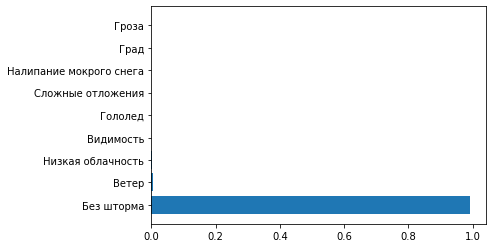

In [3]:
import matplotlib.pyplot as plt
storm = ('Без шторма', 'Ветер', 'Низкая облачность', 'Видимость', 'Гололед', 'Сложные отложения', 'Налипание мокрого снега', 'Град', 'Гроза')
fig, ax = plt.subplots()
ax.barh(storm, np.squeeze(predictions))

In [59]:
predictions

array([[9.0020454e-01, 6.3475437e-02, 4.1492796e-03, 1.4172141e-02,
        1.2556474e-04, 1.1439071e-04, 1.4989463e-03, 2.7114199e-04,
        1.5988586e-02]], dtype=float32)